## Load packages

In [1]:
%matplotlib inline 
import rdflib, glob, pandas as pd
from rdflib.namespace import RDF, RDFS

## Define namespaces

In [2]:
abri = rdflib.Namespace("https://w3id.org/schottlaender/4.0/instance/")
abrw = rdflib.Namespace("https://w3id.org/schottlaender/4.0/work/")
abra = rdflib.Namespace("https://w3id.org/schottlaender/4.0/agent/")
abrp = rdflib.Namespace("https://w3id.org/schottlaender/4.0/place/")
bf = rdflib.Namespace("http://id.loc.gov/ontologies/bibframe/")
arm = rdflib.Namespace("https://w3id.org/arm/")

## Parse all .ttl files in subdirectories into a graph

In [3]:
def initialize_abr_graph():
    g = rdflib.Graph()
    g.bind("abri", "https://w3id.org/schottlaender/4.0/instance/")
    g.bind("abrw", "https://w3id.org/schottlaender/4.0/work/")
    g.bind("abra", "https://w3id.org/schottlaender/4.0/agent/")
    g.bind("abrp", "https://w3id.org/schottlaender/4.0/place/")
    g.bind("bf", "http://id.loc.gov/ontologies/bibframe/")
    g.bind("arm", "https://w3id.org/arm/")
    return g

In [4]:
g = initialize_abr_graph()
for infile in glob.glob("ttl/*/*.ttl"):
    g.parse(infile, format='n3')
n = len(g)
print(f"ABR graph has {n} triples.")

ABR graph has 7473 triples.


## Walk the graph to display instances for a work

In [5]:
def publication(inst):
    for pa in g.objects(inst, bf.provisionActivity):
        place = g.value(pa, bf.place)
        place_name = g.value(place, RDFS.label)
        agent = g.value(pa, bf.agent)
        agent_name = g.value(agent, RDFS.label)
        date = g.value(pa, bf.date)
        if place_name and date and agent_name:
            break
    return f"{place_name}: {agent_name}, {date}"

In [6]:
for s,p,o in g.triples( (abrw['A8'], bf.hasInstance, None) ):
    print('{}. {}.'.format(g.value(g.value(o, bf.title), RDFS.label), publication(o)))
    for note in g.objects(o, bf.note):
        print('    - {}'.format(g.value(note, RDF.value)))
    print('')

The Yage Letters. [San Francisco]: City Lights Books, 1975.
    - Softbound (no hardbound issued).
    - 2nd ed.
    - [See Section C below]
    - 7 (Autumn 1957).
    - Expanded to include an additional letter, dated 10 July 1953, originally published in Black Mountain Review No.

The Yage Letters. [San Francisco]: City Lights Books, 1988.
    - [See Section C below]
    - Expanded to include “Roosevelt After Inauguration,” originally published in The Floating Bear, No.
    - 3rd ed.
    - 9 (1961).
    - Softbound (no hardbound issued).

The Yage Letters. [San Francisco]: City Lights Books, 1990.
    - Softbound (no hardbound issued).
    - This actually appears to be a new printing of the 3rd ed., above.
    - 4th [sic] ed.
    - ©1975.

The Yage Letters Redux. [San Francisco]: City Lights Books, 2006.
    - 4th ed.
    - xlvii-xlviii.
    - “Redux makes a large number of changes and corrections—around 250—most of which are small ... the  Appendix section ... include[s] previously u

## Query the graph to plot publications over year

### Query graph to get instance dates and express results as list of lists

In [7]:
qres = g.query(
    """SELECT DISTINCT ?i ?d
       WHERE {
          ?i rdf:type bf:Instance .
          ?i bf:provisionActivity ?a .
          ?a bf:date ?d .
       }""")

instance_dates = [ [row[0].toPython(), row[1].toPython() ] for row in qres ]

### Load instance dates into a datadrame and plot publications by year

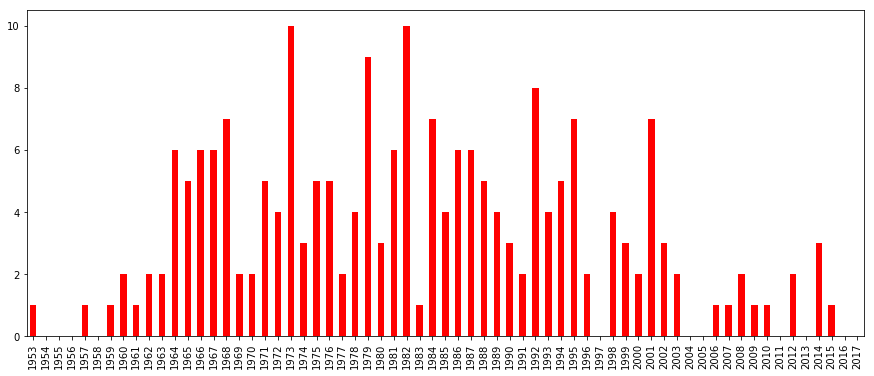

In [8]:
df = pd.DataFrame(instance_dates, columns=['instance', 'date'])
df['year'] = df['date'].str.extract('(\d\d\d\d)', expand=False)
pub_years = df['year'].value_counts().to_dict()
for year in range(1953, 2018):
    if '{}'.format(year) not in pub_years:
        pub_years['{}'.format(year)] = 0
pub_df = pd.DataFrame({'year': pub_years })
pub_df['year'].plot(kind='bar',figsize=[15, 6], color='red')